In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import os
import numpy as np
import matplotlib.ticker as mticker

import sys
sys.path.append("..")

from plotting_tools import * 

In [2]:
memilio_pop = 8
ww_data_dir = os.path.join("..", "..", "..", "preprocessing", "preprocessed_data", f"pop{memilio_pop}")
substances_dir = os.path.join(ww_data_dir, "substances")
hydraulics_dir = os.path.join(ww_data_dir, "hydraulics")

plot_path = f"../plots/Figure_5"
os.makedirs(plot_path, exist_ok=True)

In [20]:
# define plot settings
sampling_locations = ["S_Ub", "S_M2", "Overall"]

custom_palette = {
    'Ref. (no rain or decay)': "#595959",
    'Unnormalized': "#3B75AF",
    'Normalized with PMMoV': "#83AF63",
    'Normalized with flow rates': "#F28C28"
}

In [4]:
def load_ww_data(file_path, manhole_col_name):
    df = pd.read_csv(file_path)
    df = df[df[manhole_col_name].isin(manhole_names.keys())]
    df["location"] = df[manhole_col_name].map(manhole_names)
    return df

In [5]:
# load substance data
df_ww = load_ww_data(os.path.join(substances_dir, "decay_Rain_output_scaled.csv"), "manhole")
df_ww = df_ww.loc[df_ww['location'].isin(sampling_locations)]

df_ww_ref = load_ww_data(os.path.join(substances_dir, "no_decay_noRain_output_scaled.csv"), "manhole") # note: decay does not affect PMMoV
df_ww_ref = df_ww_ref.loc[df_ww_ref['location'].isin(sampling_locations)]

In [11]:
min_time = df_ww["time_in_minutes"].min()
max_time = df_ww["time_in_minutes"].max() - 1

In [6]:
# load flow rate data - ca. 2.5min
df_fr = load_ww_data(os.path.join(hydraulics_dir, "decay_Rain_output.csv"), "pipe_number")
df_fr = df_fr.loc[df_fr['location'].isin(sampling_locations)]

df_fr["time"] = pd.to_datetime(start_date) + pd.to_timedelta(df_fr["time_in_minutes"], unit="min")
df_fr = df_fr.set_index("time").groupby(["simulation_id", "location"]).resample("15min", include_groups = False).ffill().reset_index()

df_fr["time_in_minutes"] = ((df_fr["time"] - pd.to_datetime(start_date)).dt.total_seconds() / 60).astype("int64")
df_fr["time_in_days"] = df_fr["time_in_minutes"] / (60 * 24)

In [7]:
# load reference flow rate data - ca. 2.5min
df_fr_ref = load_ww_data(os.path.join(hydraulics_dir, "no_decay_noRain_output.csv"), "pipe_number") # note: decay does not affect flow rates
df_fr_ref = df_fr_ref.loc[df_fr_ref['location'].isin(sampling_locations)]

df_fr_ref["time"] = pd.to_datetime(start_date) + pd.to_timedelta(df_fr_ref["time_in_minutes"], unit="min")
df_fr_ref = df_fr_ref.set_index("time").groupby(["simulation_id", "location"]).resample("15min", include_groups=False).ffill().reset_index()

df_fr_ref["time_in_minutes"] = ((df_fr_ref["time"] - pd.to_datetime(start_date)).dt.total_seconds() / 60).astype("int64")
df_fr_ref["time_in_days"] = df_fr_ref["time_in_minutes"] / (60 * 24)

In [8]:
# normalize wrt flow rates
mean_fr = df_fr_ref.groupby(["location", "simulation_id"])["value"].mean().reset_index().rename(columns={"value": "mean_fr"}) 

# rolling_window = "1.5h"
# rolling_values = df_fr.set_index("time").groupby(["simulation_id", "location"])["value"].rolling(pd.Timedelta(rolling_window)).mean().reset_index().rename(columns={"value": "value_rolling"})
# df_fr = pd.merge(df_fr, rolling_values, on=["simulation_id", "location", "time"], how = "left")

df_fr = pd.merge(df_fr, mean_fr, on=["location", "simulation_id"], how="left")
df_fr["flow_norm_factor"] = df_fr["value"] / df_fr["mean_fr"]
df_fr.loc[df_fr["mean_fr"].eq(0), "flow_norm_factor"] = np.nan

df_ww_covid = df_ww[(df_ww["variable"] == "COV19")].rename(columns={'value': 'raw_covid'})
df_ww_covid = pd.merge(df_ww_covid.loc[:,["time_in_minutes", "simulation_id", "raw_covid", "location"]], df_fr.loc[:,["time_in_minutes", "simulation_id", "flow_norm_factor", "location"]], on=["location", "simulation_id", "time_in_minutes"], how="outer")
df_ww_covid["flow_norm_covid"] = df_ww_covid["raw_covid"] * df_ww_covid["flow_norm_factor"]

In [9]:
# normalize wrt PMMoV
mean_PMMoV = df_ww_ref[(df_ww_ref["variable"] == "PMMoV")].groupby(["location", "simulation_id"])["value"].mean().reset_index().rename(columns={"value": "mean_PMMoV"}) 

norm_factors_PMMoV = df_ww[(df_ww["variable"] == "PMMoV")].copy()
norm_factors_PMMoV = pd.merge(norm_factors_PMMoV, mean_PMMoV, on=["location", "simulation_id"], how="left")
norm_factors_PMMoV = norm_factors_PMMoV.rename(columns={"value": "PMMoV_measured"})
norm_factors_PMMoV["PMMoV_norm_factor"] = norm_factors_PMMoV["mean_PMMoV"] / norm_factors_PMMoV["PMMoV_measured"]
norm_factors_PMMoV.loc[norm_factors_PMMoV["PMMoV_measured"].eq(0), "PMMoV_norm_factor"] = np.nan

df_ww_covid = pd.merge(df_ww_covid.loc[:,["time_in_minutes", "location", "simulation_id", "raw_covid", "flow_norm_covid", "flow_norm_factor"]], norm_factors_PMMoV.loc[:,["PMMoV_norm_factor", "location", "simulation_id", "time_in_minutes", "PMMoV_measured"]], 
                       on=["location", "simulation_id", "time_in_minutes"], how="outer")
df_ww_covid["PMMoV_norm_covid"] = df_ww_covid["raw_covid"] * df_ww_covid["PMMoV_norm_factor"]

In [12]:
# create combined dataframe with reference, measured, PMMoV normalized, and FR normalized COVID concentrations
df_ww_ref_covid = df_ww_ref[(df_ww_ref["variable"] == "COV19")].rename(columns={'value': 'ref_covid'})

df_combined = df_ww_covid.merge(df_ww_ref_covid, on=["time_in_minutes", "location", "simulation_id"], how="outer")
df_combined["Date"] = pd.to_datetime(start_date) + pd.to_timedelta(df_combined["time_in_minutes"], unit="min")

df_combined = df_combined[(df_combined["time_in_minutes"] >= min_time) & (df_combined["time_in_minutes"] <= max_time)]

for col in ["flow_norm_factor","PMMoV_norm_factor","flow_norm_covid","PMMoV_norm_covid","ref_covid","raw_covid"]:
    if col in df_combined:
        df_combined[col] = df_combined[col].replace([np.inf, -np.inf], np.nan)

In [13]:
print("PMMoV_measured == 0 rows:", (norm_factors_PMMoV["PMMoV_measured"].fillna(0)==0).sum())
print("PMMoV_norm_covid: inf =", np.isinf(df_combined["PMMoV_norm_covid"]).sum(),
      "NaN =", df_combined["PMMoV_norm_covid"].isna().sum())
print("flow_norm_covid: inf =", np.isinf(df_combined["flow_norm_covid"]).sum(),
      "NaN =", df_combined["flow_norm_covid"].isna().sum())

PMMoV_measured == 0 rows: 1702
PMMoV_norm_covid: inf = 0 NaN = 1702
flow_norm_covid: inf = 0 NaN = 0


In [ ]:
# df_combined.to_csv(os.path.join(substances_dir, "decay_Rain_output_scaled_norm.csv"))

In [16]:
precipitation = pd.read_csv("rain/rain.txt", decimal=",", sep=";", header=None, skiprows=1).reset_index()
precipitation.columns = ["date", "rain"]
precipitation['date'] = pd.date_range(start=start_date, periods=len(precipitation), freq="5min")

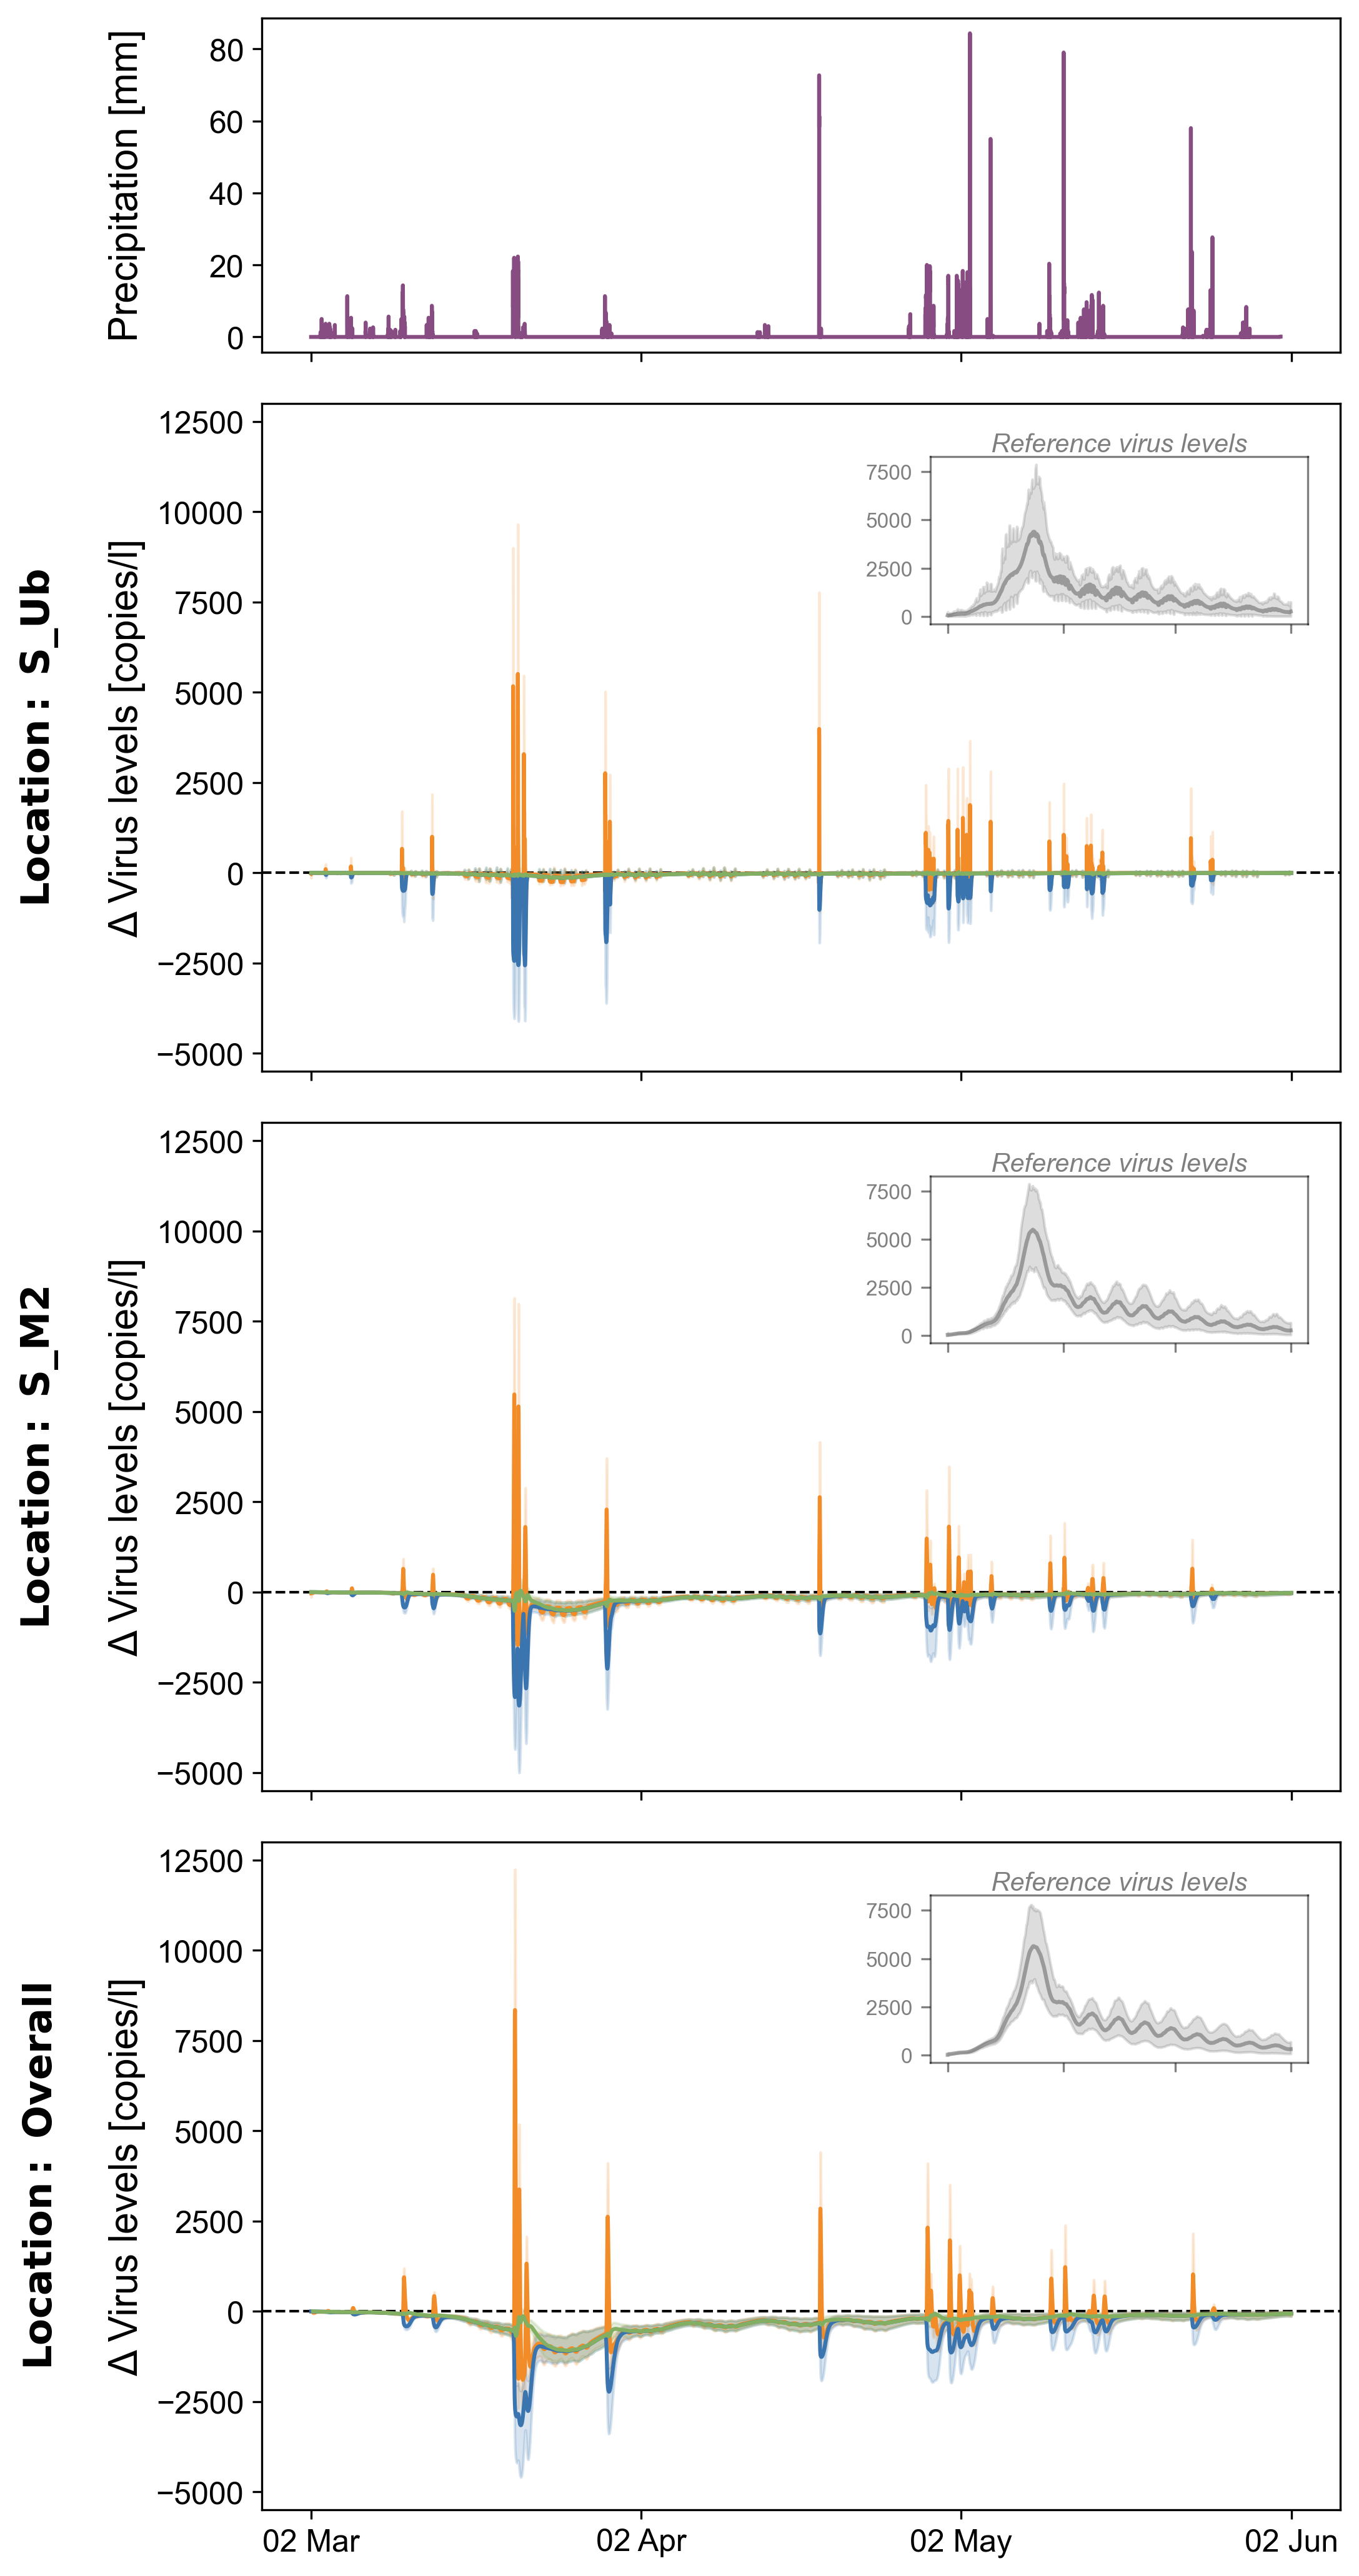

In [26]:
plt.style.use('default')
set_fontsize()

p95_envelope = (df_combined.groupby(["location", "Date"])["ref_covid"].quantile(0.95).reset_index(name="p95"))
ref_max = p95_envelope["p95"].max()
ref_min = np.nanmin(df_combined["ref_covid"].values)
pad = 0.05 * max(ref_max - ref_min, 1.0)

fig, axs = plt.subplots(nrows = 4, figsize = (7.5, 14), dpi = 300, sharex = True, sharey = False, gridspec_kw={"height_ratios": [1, 2, 2, 2]})

ax_precip = axs[0]
ax_precip.plot(precipitation["date"], precipitation["rain"], color="#874C82")
ax_precip.xaxis.set_major_locator(mdates.DayLocator(bymonthday=2))
ax_precip.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
ax_precip.set_ylabel("Precipitation [mm]")

for i, (sampling_location, ax) in enumerate(zip(sampling_locations, axs[1:])):

    to_plot = df_combined[df_combined["location"] == sampling_location].copy()
    to_plot["Unnormalized"] = to_plot["raw_covid"] - to_plot["ref_covid"]
    to_plot["Normalized with PMMoV"] = to_plot["PMMoV_norm_covid"] - to_plot["ref_covid"]
    to_plot["Normalized with flow rates"] = to_plot["flow_norm_covid"] - to_plot["ref_covid"]

    diff_df = to_plot[["Date", "Unnormalized", "Normalized with PMMoV", "Normalized with flow rates"]].melt(id_vars="Date", var_name="Method", value_name="Difference")

    ax.axhline(0, color='black', linestyle='--', linewidth=1, zorder=1)
    sns.lineplot(data=diff_df, x="Date", y="Difference", hue="Method", ax=ax, errorbar=("pi", 90), hue_order=["Normalized with flow rates", "Unnormalized", "Normalized with PMMoV"], palette=custom_palette)
    ax.set_xlabel("")
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
    ax.legend_.remove()
    ax.set_ylim(-5500, 13000)
    
    escaped_location = sampling_location.replace('_', r'\_')
    ax.set_ylabel(f"$\\mathbf{{Location:\\ {escaped_location}}}$\n\nΔ Virus levels [copies/l]")

    # --- inset: reference series (top-right corner)
    # [left, bottom, width, height] in axes fraction coordinates
    axin = ax.inset_axes([0.62, 0.67, 0.35, 0.25])
    sns.lineplot(data=to_plot, x="Date", y="ref_covid", ax=axin, errorbar=("pi", 90), color = "#595959", alpha = 0.5)

    axin.set_ylim(ref_min - pad, ref_max + pad)

    axin.set_title("Reference virus levels", fontsize= 10, pad=2, fontstyle='italic', alpha=0.5)
    
    axin.tick_params(colors="0.5")
    axin.xaxis.set_major_locator(mdates.DayLocator(bymonthday=2))
    axin.set_xlabel("")
    axin.set_ylabel("")
    axin.set_xticklabels([])
    axin.tick_params(axis="x", which="both", labelsize=0)
    axin.tick_params(axis="y", labelsize=8)
    axin.yaxis.set_major_locator(mticker.MaxNLocator(nbins=4))
    for spine in axin.spines.values():
        spine.set_alpha(0.5)

fig.tight_layout()
fig.align_ylabels(axs)
fig.savefig(os.path.join(plot_path, "diff_plot_all_locations_ref_inset.png"), dpi=300)

In [27]:
# calculate absolute error metrics
df_combined["AE_raw"] = abs(df_combined["raw_covid"] - df_combined["ref_covid"])
df_combined["AE_PMMoV"] = abs(df_combined["PMMoV_norm_covid"] - df_combined["ref_covid"])
df_combined["AE_fr"] = abs(df_combined["flow_norm_covid"] - df_combined["ref_covid"])

In [28]:
# format metrics df for plotting
df_metrics = df_combined[["time_in_days", "location", "simulation_id", "AE_raw", "AE_PMMoV", "AE_fr"]]

df_metrics_long = pd.melt(df_metrics, id_vars=["time_in_days", "location", "simulation_id"], value_vars=["AE_raw", "AE_PMMoV", "AE_fr"], var_name="category", value_name="value")

df_metrics_long = df_metrics_long[df_metrics_long["location"].isin(sampling_locations)]
df_metrics_long["category"] = df_metrics_long["category"].replace({"AE_raw": "Unnormalized", "AE_PMMoV": "Normalized with PMMoV", "AE_fr": "Normalized with flow rates"})
df_metrics_long = df_metrics_long.dropna(subset=["value"])

In [29]:
def crosscorr(data_x, data_y, lag=0):
    return data_x.corr(data_y.shift(lag))

def get_crosscorr_for_one_station(df_for_ccf, location, lags_in_hours, concentration_col):
    df_for_ccf_sub = df_for_ccf.loc[df_for_ccf.location==location, :].sort_values("time_in_hours")
    return [crosscorr(df_for_ccf_sub[concentration_col], df_for_ccf_sub["prevalence"], lag) for lag in lags_in_hours]

def get_ccf_for_sel_stations(concentration_col):
    results = []
    for location in sampling_locations:
        loc_corr = []
        for sim in df_prevalence['memilio_id'].unique():
            curr_sim_ww = df_combined.loc[df_combined['simulation_id'] == sim]
            curr_sim_prev = df_prevalence.loc[df_prevalence['memilio_id'] == sim]
            curr_combined = curr_sim_ww.merge(curr_sim_prev, left_on="time_in_hours", right_on="t", how="left")
            loc_corr.append(get_crosscorr_for_one_station(curr_combined, str(location), range(-max_lag_hours, max_lag_hours + 1, 1), concentration_col))
        df_corr = pd.DataFrame(loc_corr)
        results.append(df_corr.mean(axis = 0))
    results = pd.DataFrame(results).transpose()
    results.columns = sampling_locations
    results["lag_in_h"] = range(-max_lag_hours, max_lag_hours + 1, 1)
    return results.set_index("lag_in_h")

In [31]:
# load in prevalence data
def load_prevalence_data(memilio_id):
    df = pd.read_csv(f"../../../raw_memilio_data/pop{memilio_pop}/comps/{memilio_id}_comps.csv", sep=" ", index_col=False)
    
    df = df[["t", "S", "E", "Ins", "Isy", "Isev", "Icri", "R", "D"]]
    df["prevalence"] = df["E"] + df["Ins"] + df["Isy"] + df["Isev"] + df["Icri"]
    df["memilio_id"] = memilio_id
    
    return df[["t", "memilio_id", "prevalence"]]

df_prevalence = pd.concat([load_prevalence_data(memilio_id) for memilio_id in range(1, 101)])

In [32]:
# find ccf between prevalence data and 4 sets of ww data for selected sampling locations
df_combined["time_in_hours"] = df_combined["time_in_days"] * 24
max_lag_hours = 7 * 24

ccf_raw = get_ccf_for_sel_stations("raw_covid")
ccf_PMMoV  = get_ccf_for_sel_stations("PMMoV_norm_covid")
ccf_fr  = get_ccf_for_sel_stations("flow_norm_covid")
ccf_ref  = get_ccf_for_sel_stations("ref_covid")

In [33]:
# format ccfs for plotting
for df_ccf, name in zip([ccf_ref, ccf_raw, ccf_PMMoV, ccf_fr], ["Reference", "Unnormalized", "Normalized with PMMoV", "Normalized with flow rates"]):
    df_ccf["scenario"] = name

all_ccf_df = pd.concat([ccf_ref, ccf_raw, ccf_PMMoV, ccf_fr])

max_ccfs = all_ccf_df.groupby('scenario')[sampling_locations].max().reset_index()
max_ccfs_long = pd.melt(max_ccfs, id_vars=["scenario"], value_vars= sampling_locations, var_name="location", value_name="max_ccf")

ccf_cols = [col for col in max_ccfs.columns if col != 'scenario']
ref_ccfs = max_ccfs.loc[max_ccfs['scenario'] == 'Reference', ccf_cols].iloc[0]
ccf_diffs = max_ccfs.copy()
ccf_diffs[ccf_cols] = ref_ccfs - ccf_diffs[ccf_cols] 
ccf_diffs_long = pd.melt(ccf_diffs, id_vars=["scenario"], value_vars= sampling_locations, var_name="location", value_name="ccf_diff")
ccf_diffs_long = ccf_diffs_long[ccf_diffs_long['scenario'] != 'Reference']
max_ccfs_long.head(30)

,scenario,location,max_ccf
0,Normalized with PMMoV,S_Ub,0.870318
1,Normalized with flow rates,S_Ub,0.859097
2,Reference,S_Ub,0.875148
3,Unnormalized,S_Ub,0.833955
4,Normalized with PMMoV,S_M2,0.925816
5,Normalized with flow rates,S_M2,0.900165
6,Reference,S_M2,0.928123
7,Unnormalized,S_M2,0.868140
8,Normalized with PMMoV,Overall,0.923693
9,Normalized with flow rates,Overall,0.868422


In [34]:
precipitation = precipitation.set_index("date")
precipitation["cumulative_rain"] = precipitation["rain"].rolling("1h").sum() # may want to increase to e.g., 6h instead due to travel times!
precipitation = precipitation.reset_index()
df_combined = pd.merge(df_combined, precipitation, left_on="Date", right_on = "date", how = "left")

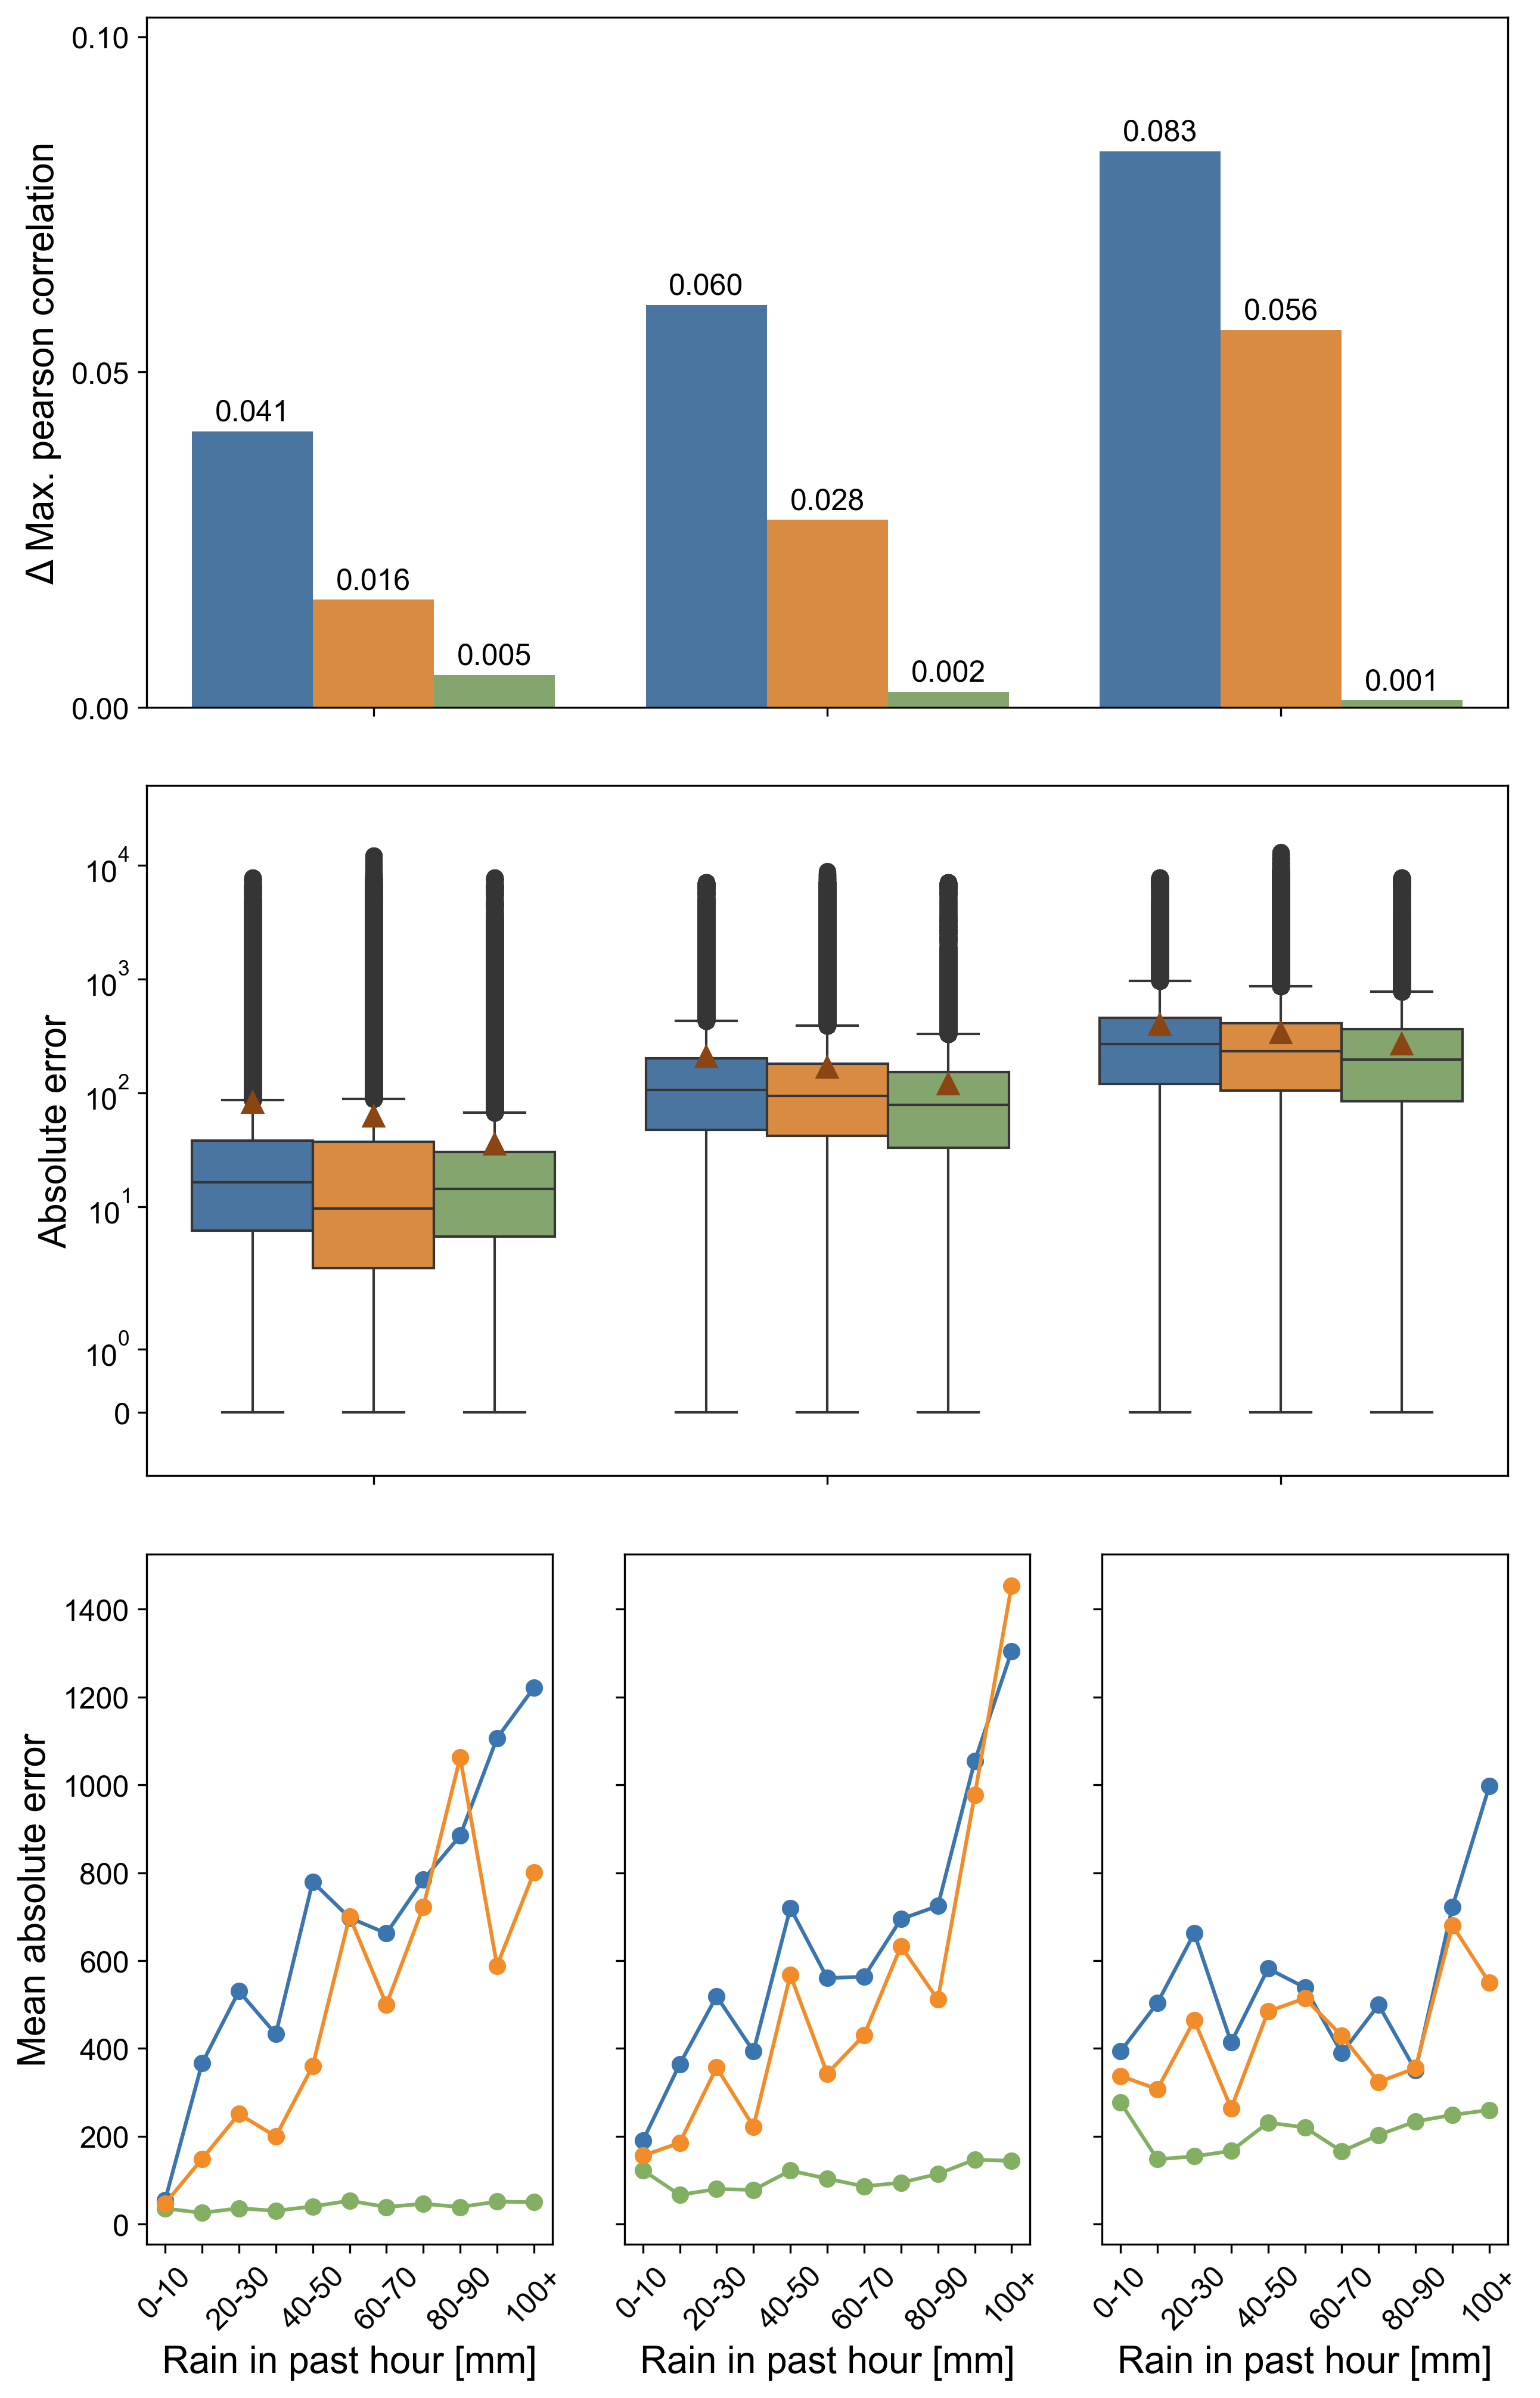

In [37]:
plt.style.use('default')
set_fontsize()

fig = plt.figure(figsize=(8.5, 13.3), dpi=300, constrained_layout=True)
gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 1])  

# CCF bar plot
ax2 = fig.add_subplot(gs[0, :]) 
sns.barplot(x='location', y='ccf_diff', data=ccf_diffs_long, 
            hue='scenario', hue_order=["Unnormalized", "Normalized with flow rates", "Normalized with PMMoV"], 
            palette=custom_palette, ax=ax2)
ax2.set_ylabel("Δ Max. pearson correlation")
ax2.set_xlabel(" ")
ax2.set_xticklabels([])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.05)) 
ax2.set_ylim(0, ccf_diffs_long["ccf_diff"].max() + 0.02)
for container in ax2.containers:
    ax2.bar_label(container, fmt="%.3f", label_type='edge', padding=2, fontsize=12)
ax2.legend_.remove()

# AE box plot
ax1 = fig.add_subplot(gs[1, :]) 
sns.boxplot(x="location", y="value", hue="category", palette=custom_palette, 
            data=df_metrics_long, ax=ax1, order=sampling_locations, 
            hue_order=["Unnormalized", "Normalized with flow rates", "Normalized with PMMoV"],
            showmeans=True, 
            meanprops={'markerfacecolor':"#8B4513",'markeredgecolor':"#8B4513", 'markersize': 8})
ax1.set_ylabel("Absolute error")
ax1.set_xlabel(" ")
ax1.set_xticklabels([])
ax1.set_yscale('symlog')
ax1.set(ylim=(-1, 50000))
ax1.legend_.remove()

# AE vs. rain scatterplot
ax_s0 = fig.add_subplot(gs[2, 0])
ax_s1 = fig.add_subplot(gs[2, 1], sharey=ax_s0)
ax_s2 = fig.add_subplot(gs[2, 2], sharey=ax_s0)
axes_scatter = [ax_s0, ax_s1, ax_s2]

bins = list(range(0, 101, 10)) + [np.inf]
labels = [f"{i}-{i+10}" for i in range(0, 100, 10)] + ["100+"]

scatter_colors = {
    "AE_raw": custom_palette['Unnormalized'],
    "AE_PMMoV": custom_palette['Normalized with PMMoV'],
    "AE_fr": custom_palette['Normalized with flow rates']
}

for i, loc in enumerate(sampling_locations): 
    df = df_combined[df_combined["location"] == loc].copy()
    df["Rain_Category"] = pd.cut(df["cumulative_rain"], bins=bins, labels=labels, right=False)
    mean_errors = df.groupby("Rain_Category", observed=False)[["AE_raw", "AE_PMMoV", "AE_fr"]].mean()

    ax = axes_scatter[i]
    for col in mean_errors.columns:
        ax.plot(mean_errors.index.astype(str), mean_errors[col], marker='o', label=col, color=scatter_colors[col])
        
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels([label if j % 2 == 0 else "" for j, label in enumerate(labels)], rotation=45)

    #ax.set_title(f"Location: {loc}")
    ax.set_xlabel("Rain in past hour [mm]")
    if i == 0:
        ax.set_ylabel("Mean absolute error")
    else:
        ax.set_ylabel("")
        ax.yaxis.set_tick_params(labelleft=False)

fig.savefig(os.path.join(plot_path, "norm_summary_combined.png"), dpi=300)
plt.show()